In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Import data
crimedata = pd.read_csv('../input/crimes-in-boston/crime.csv', encoding='latin-1')

crime0 = crimedata.loc[crimedata['YEAR'].isin([2016,2017])]

crime = crime0.loc[crime0['UCR_PART'] == 'Part One']

#Remove unused columns
del crime['INCIDENT_NUMBER'] 
del crime['OFFENSE_CODE']
del crime['UCR_PART']
del crime['Location']

# Peek
crime.head()

,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long
5633,Larceny,LARCENY THEFT FROM BUILDING,E5,729,NaN,2017-10-23 13:58:00,2017,10,Monday,13,VFW PKWY,42.285370,-71.172440
5919,Auto Theft,AUTO THEFT - MOTORCYCLE / SCOOTER,E18,544,NaN,2017-03-22 09:00:00,2017,3,Wednesday,9,AUSTIN ST,42.257688,-71.126418
6940,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,774,NaN,2017-03-23 12:00:00,2017,3,Thursday,12,COMMONWEALTH AVE,42.338363,-71.154410
12370,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,E13,571,NaN,2017-11-21 21:00:00,2017,11,Tuesday,21,SYLVIA ST,42.310559,-71.102854
14227,Larceny,LARCENY THEFT FROM BUILDING,D4,136,NaN,2017-12-15 16:06:00,2017,12,Friday,16,MARLBOROUGH ST,42.352569,-71.079788


In [2]:
crime[["OCCURRED_ON_DATE"]] = crime[["OCCURRED_ON_DATE"]].apply(pd.to_datetime)

# Convert OCCURED_ON_DATE to datetime


# Fill in nans in SHOOTING column
crime.SHOOTING.fillna('N', inplace=True)

# Convert DAY_OF_WEEK to an ordered category
crime.DAY_OF_WEEK = pd.Categorical(crime.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

# Replace -1 values in Lat/Long with Nan
crime.Lat.replace(-1, None, inplace=True)
crime.Long.replace(-1, None, inplace=True)

# Rename columns to something easier to type (the all-caps are annoying!)
rename = {'OFFENSE_CODE_GROUP':'Group',
         'OFFENSE_DESCRIPTION':'Description',
         'DISTRICT':'District',
         'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street'}
crime.rename(index=str, columns=rename, inplace=True)

# Check
crime.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,Group,Description,District,Area,Shooting,Date,Year,Month,Day,Hour,Street,Lat,Long
5633,Larceny,LARCENY THEFT FROM BUILDING,E5,729,N,2017-10-23 13:58:00,2017,10,Monday,13,VFW PKWY,42.285370,-71.172440
5919,Auto Theft,AUTO THEFT - MOTORCYCLE / SCOOTER,E18,544,N,2017-03-22 09:00:00,2017,3,Wednesday,9,AUSTIN ST,42.257688,-71.126418
6940,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,774,N,2017-03-23 12:00:00,2017,3,Thursday,12,COMMONWEALTH AVE,42.338363,-71.154410
12370,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,E13,571,N,2017-11-21 21:00:00,2017,11,Tuesday,21,SYLVIA ST,42.310559,-71.102854
14227,Larceny,LARCENY THEFT FROM BUILDING,D4,136,N,2017-12-15 16:06:00,2017,12,Friday,16,MARLBOROUGH ST,42.352569,-71.079788


In [3]:
print('There are '+str(crime.shape[0])+' incidents.')

There are 37538 incidents.


In [4]:
# some data checks
crime.shape

(37538, 13)

In [5]:
# checking null values
crime.isnull().count()

Group          37538
Description    37538
District       37538
Area           37538
Shooting       37538
Date           37538
Year           37538
Month          37538
Day            37538
Hour           37538
Street         37538
Lat            37538
Long           37538
dtype: int64

Below, I will create a plot which shows the most common kind of UCR_Part one crime (the most serious crimes) one crimes in the city of Boston

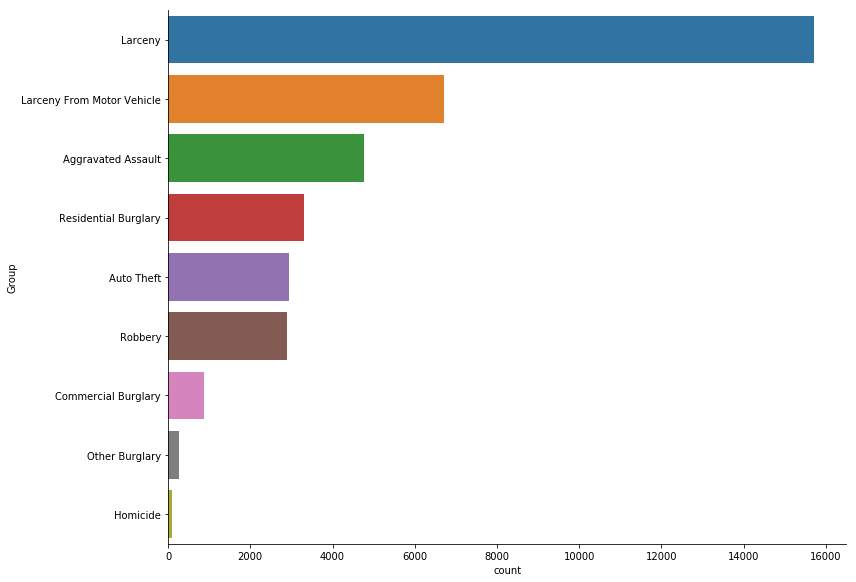

In [6]:
sns.catplot(y='Group',
           kind='count',
            height=8, 
            aspect=1.5,
            order=crime.Group.value_counts().index,
           data=crime)

Larceny is the most common sort of serious crime, and homicide is the least common. Now, let's see what time of day these crimes happen most often.

Text(-2.575000000000003, 0.5, 'Count')

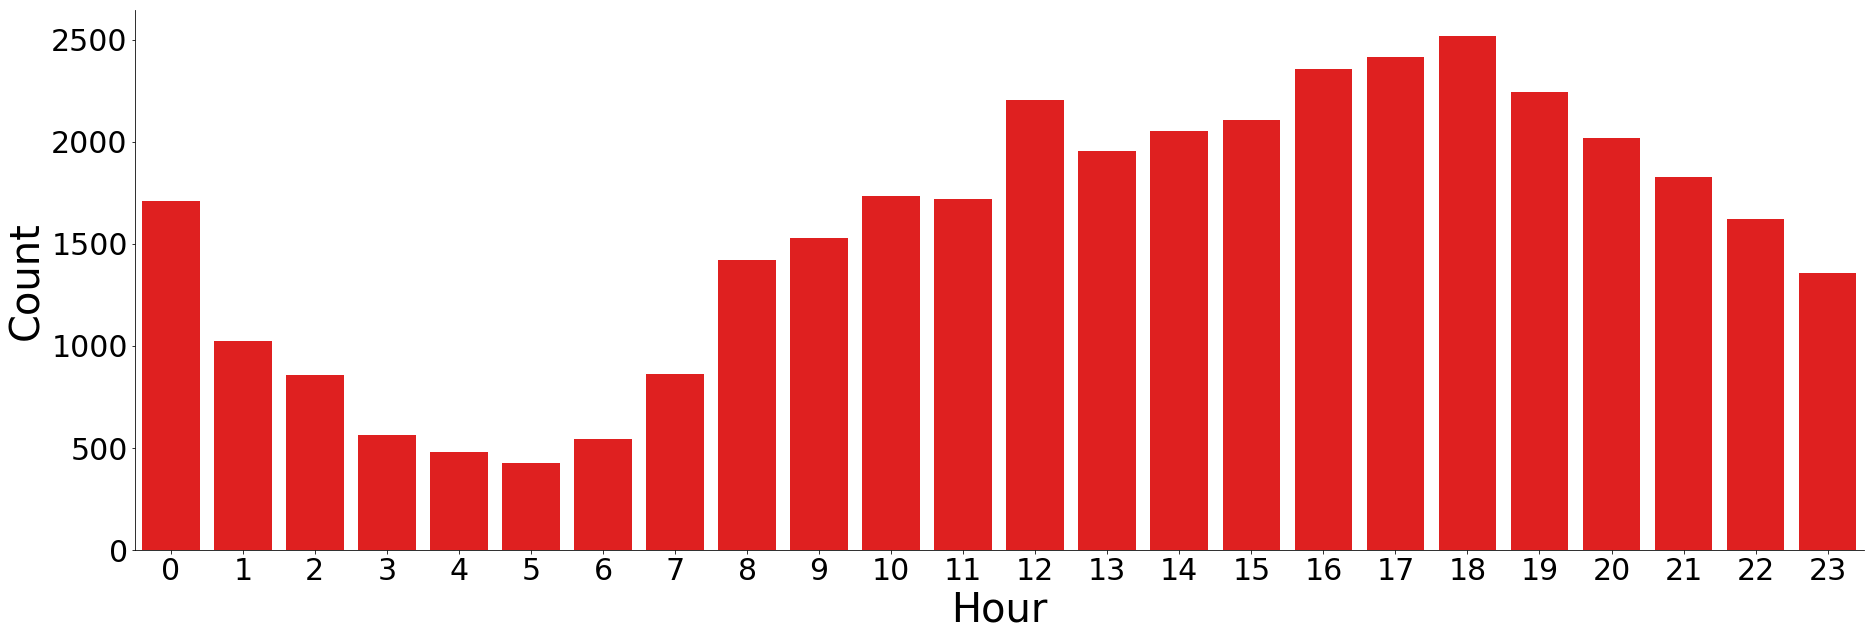

In [7]:
# Crimes by hour of the day
sns.catplot(x='Hour',
           kind='count',
            height=8.27, 
            aspect=3,
            color='red',
           data=crime)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('Count', fontsize=40)

Looks like afternoon and evening are the times of day when series crime occurs most often.

Now let's look closer at the most abundant crime in Boston, Larceny. We'll see when most larcenies happen.

In [8]:
array = ['Larceny']
larceny = crime.loc[crime['Group'].isin(array)]

array2 = ['Homicide']
homicide = crime.loc[crime['Group'].isin(array2)]

Text(-2.575000000000003, 0.5, 'Count')

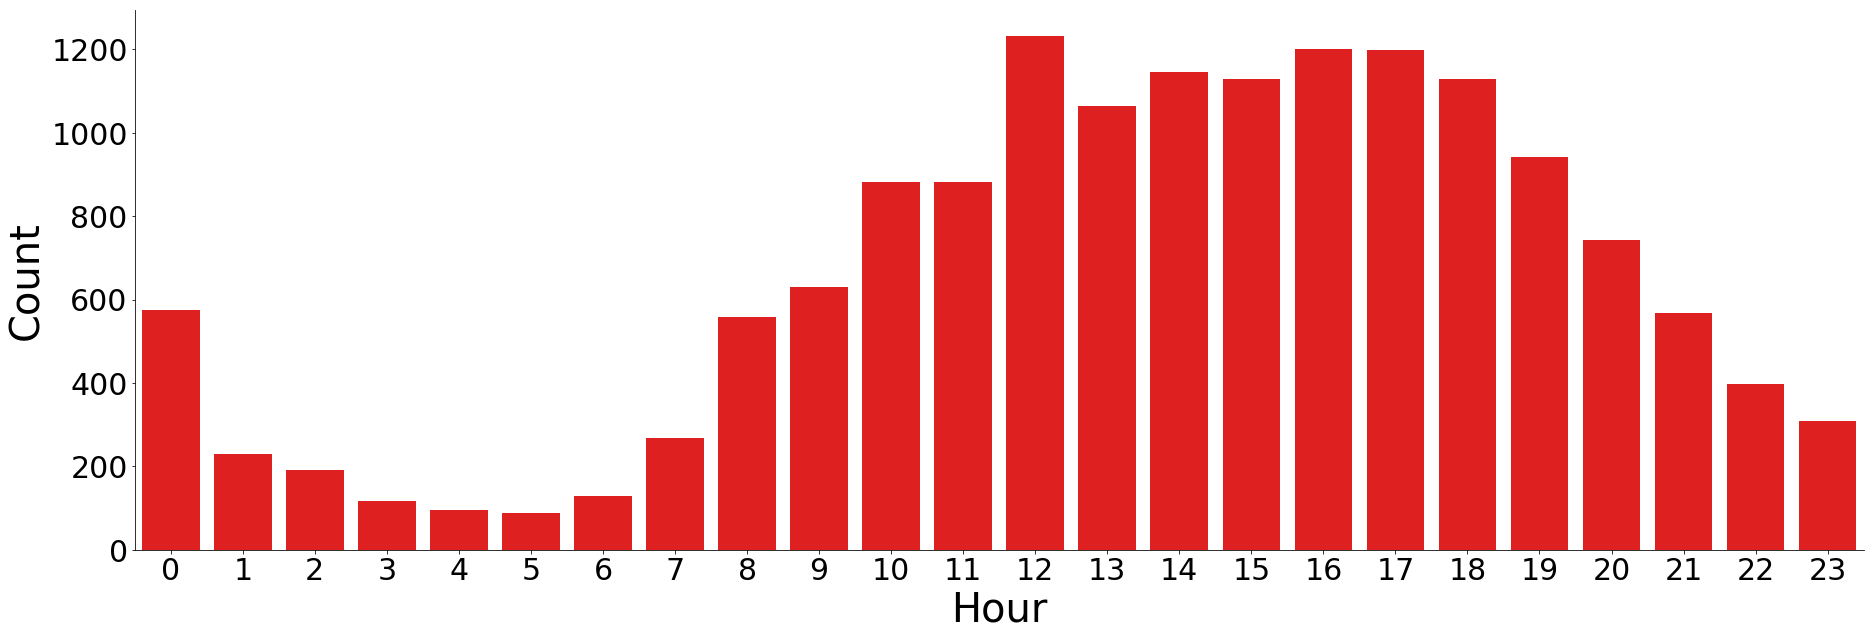

In [9]:
# Crimes by hour of the day
sns.catplot(x='Hour',
           kind='count',
            height=8.27, 
            aspect=3,
            color='red',
           data=larceny)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('Count', fontsize=40)

This plot shows that larcenies are even more highly concentrated in the afternoon and evening hours than the average of all crimes combined. There is a strange rise in larcenies around midnight.

Now let's see what day of the week on which serious crimes are most committed.

In [10]:
crime.groupby('Day').count()

,Group,Description,District,Area,Shooting,Date,Year,Month,Hour,Street,Lat,Long
Day,,,,,,,,,,,,
Monday,5247,5247,5218,5247,5247,5247,5247,5247,5247,5093,4988,4988
Tuesday,5466,5466,5444,5466,5466,5466,5466,5466,5466,5325,5229,5229
Wednesday,5353,5353,5334,5353,5353,5353,5353,5353,5353,5204,5109,5109
Thursday,5337,5337,5316,5337,5337,5337,5337,5337,5337,5197,5106,5106
Friday,5667,5667,5650,5667,5667,5667,5667,5667,5667,5492,5391,5391
Saturday,5398,5398,5382,5398,5398,5398,5398,5398,5398,5255,5132,5132
Sunday,5070,5070,5061,5070,5070,5070,5070,5070,5070,4953,4850,4850


Text(-2.450000000000017, 0.5, 'Count')

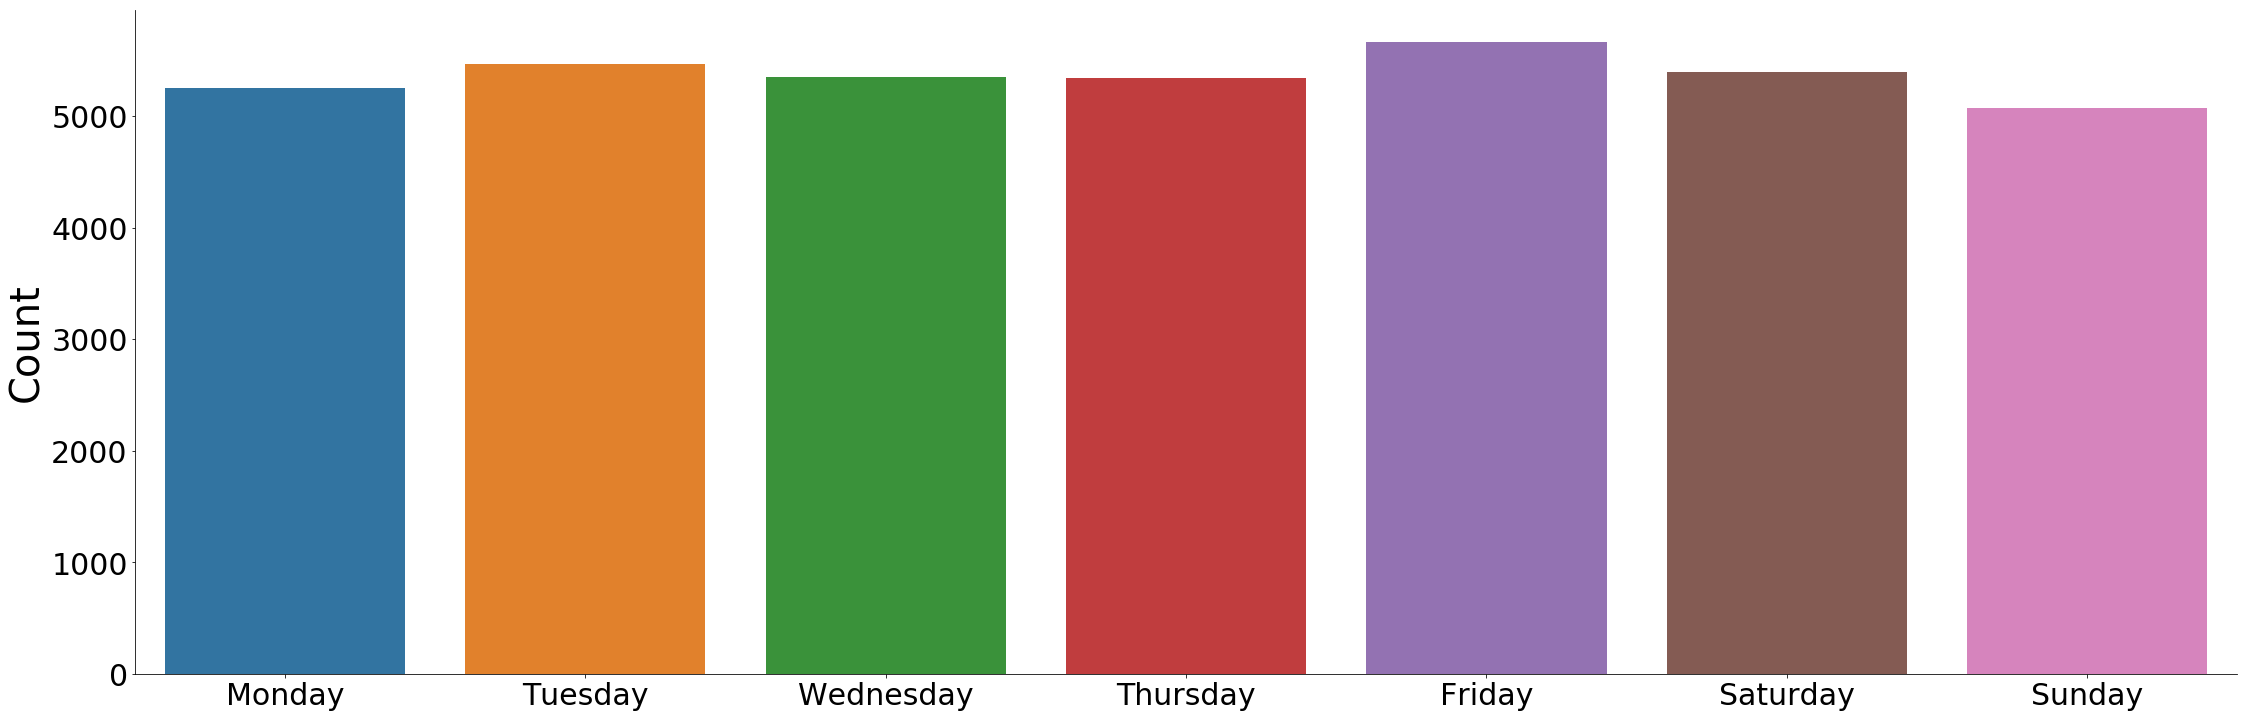

In [11]:
# Crimes by day of the week
sns.catplot(x='Day',
           kind='count',
            height=10, 
            aspect=3,
           data=crime)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

As we can see there is not a big difference in the amount of crime from day to day. But there is an obvious peak around Friday and a bit of a dip in crime on Sunday.

In [12]:
larceny.groupby('Day').count()

,Group,Description,District,Area,Shooting,Date,Year,Month,Hour,Street,Lat,Long
Day,,,,,,,,,,,,
Monday,2252,2252,2245,2252,2252,2252,2252,2252,2252,2209,2180,2180
Tuesday,2361,2361,2354,2361,2361,2361,2361,2361,2361,2333,2293,2293
Wednesday,2307,2307,2299,2307,2307,2307,2307,2307,2307,2266,2229,2229
Thursday,2305,2305,2300,2305,2305,2305,2305,2305,2305,2263,2222,2222
Friday,2385,2385,2379,2385,2385,2385,2385,2385,2385,2347,2311,2311
Saturday,2211,2211,2205,2211,2211,2211,2211,2211,2211,2177,2138,2138
Sunday,1888,1888,1885,1888,1888,1888,1888,1888,1888,1868,1823,1823


Text(-2.575000000000017, 0.5, 'Count')

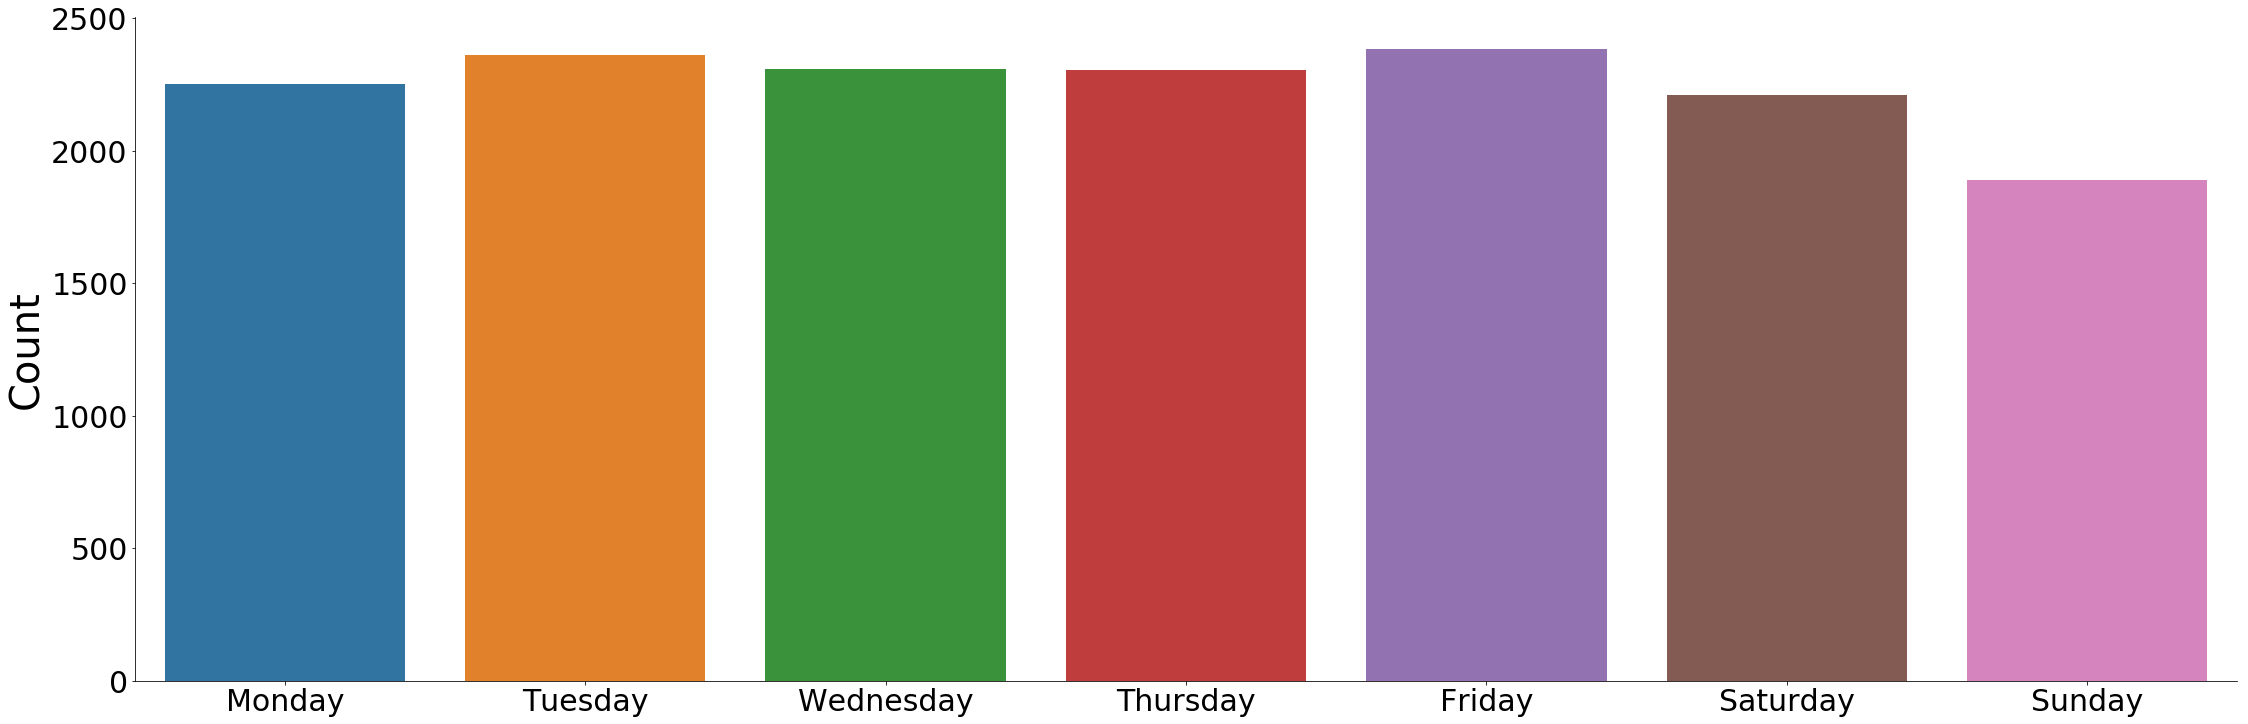

In [13]:
# Crimes by day of the week
sns.catplot(x='Day',
           kind='count',
            height=10, 
            aspect=3,
           data=larceny)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

Text(-2.5749999999999957, 0.5, 'Count')

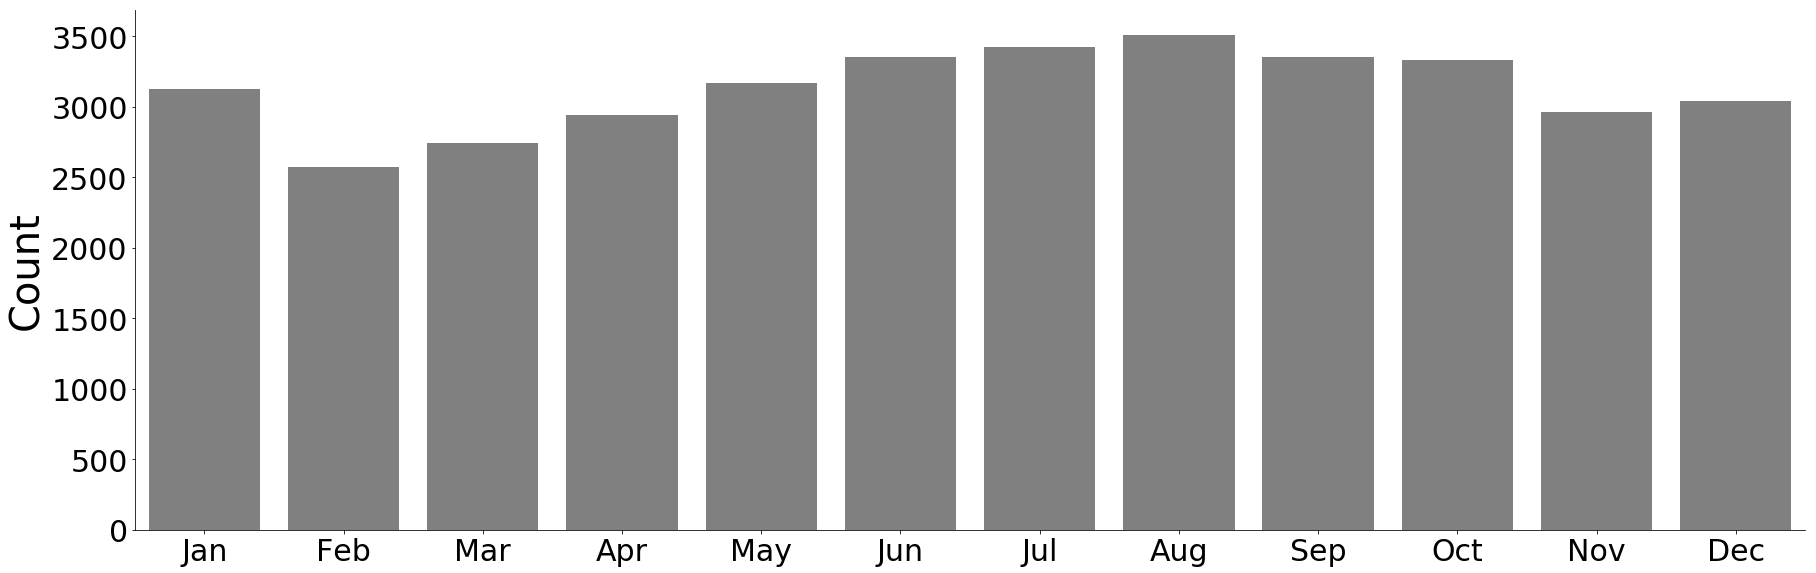

In [14]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.catplot(x='Month', kind='count', height=8, aspect=3, color='gray', data=crime)
plt.xticks(np.arange(12), months, size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

It's interesting that the hottest month of the summer and the coolest month of the winter contain the most crimes. Now let's see how how amount of larcenies per month compares to the average of all crime.

Text(-2.5749999999999957, 0.5, 'Count')

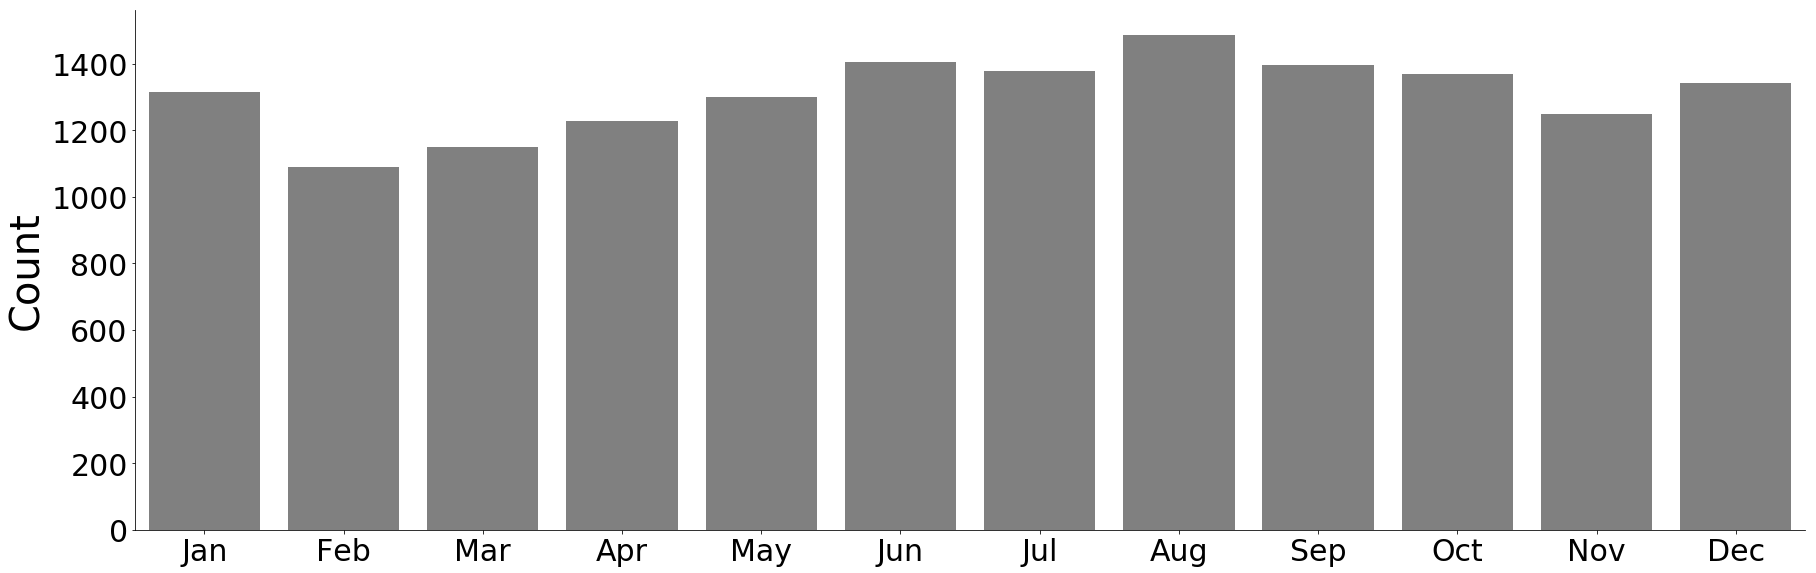

In [15]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.catplot(x='Month', kind='count', height=8, aspect=3, color='gray', data=larceny)
plt.xticks(np.arange(12), months, size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

It's about the same.

Let's see in which month homicides happen the most often.

Text(9.925000000000004, 0.5, 'Count')

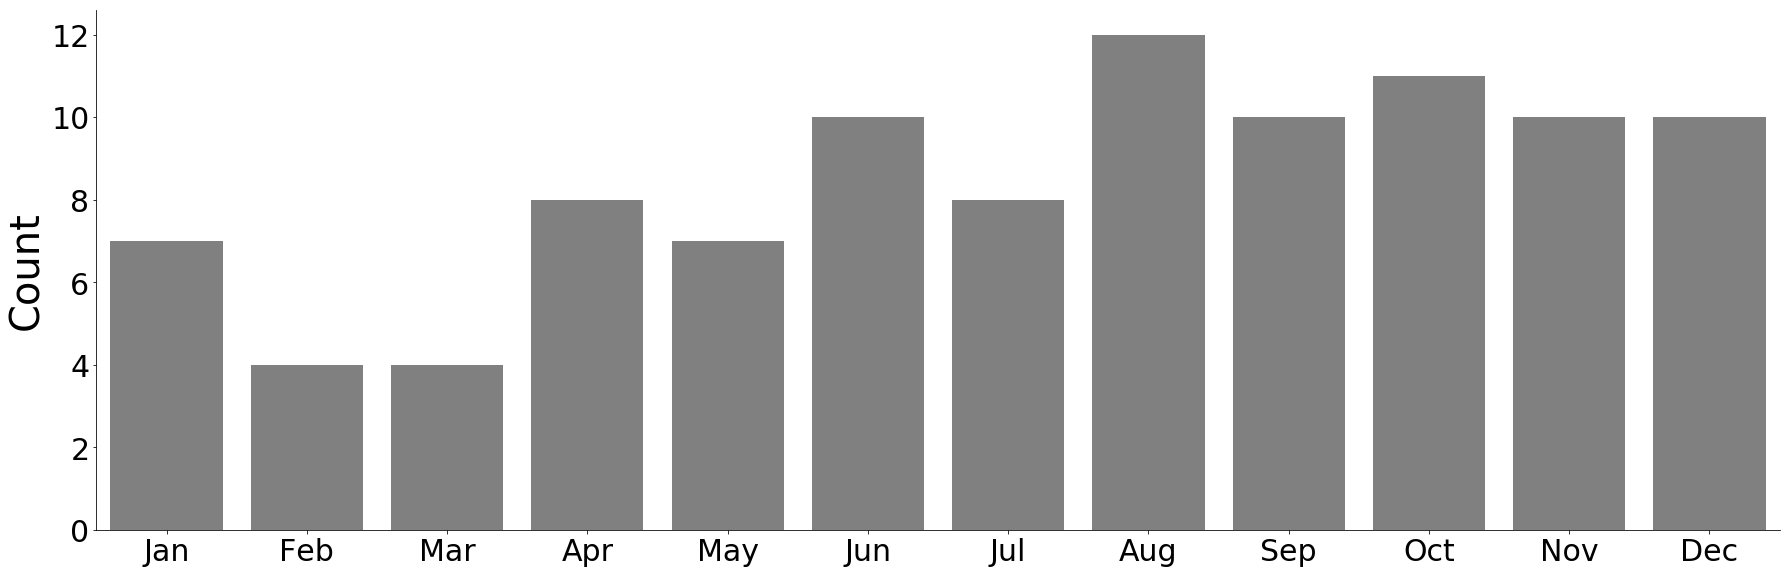

In [16]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.catplot(x='Month', kind='count', height=8, aspect=3, color='gray', data=homicide)
plt.xticks(np.arange(12), months, size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

August still falls into the pattern of having the most crime, but January does not. Interesting, I wonder what causes this difference.

Now that we have looked at time it's time to look at place. Next, I will discover where in Boston these crimes most often take place.

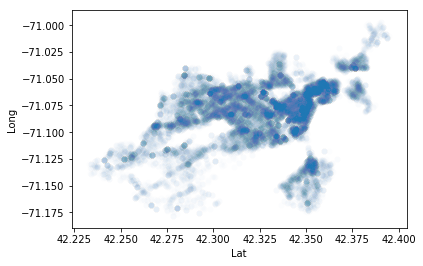

In [17]:
sns.scatterplot(x='Lat',
               y='Long',
                alpha=0.01,
               data=crime)

Now let's look at our most common crime, larceny.

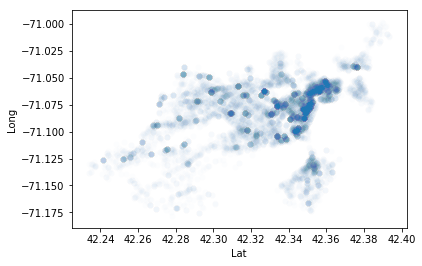

In [18]:
sns.scatterplot(x='Lat',
               y='Long',
                alpha=0.01,
               data=larceny)

It looks like most cases are concentrated to the east side of Boston. Though our crimes appear to be centered in the downtown area, there are little pockets of crime scattered around the rest of the city. Now we'll look at each district of the city.

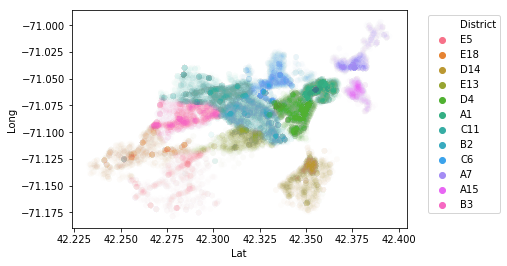

In [19]:
sns.scatterplot(x='Lat',
               y='Long',
                hue='District',
                alpha=0.01,
               data=crime)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Below, I will make a map on which will be plotted all the crimes across Boston.

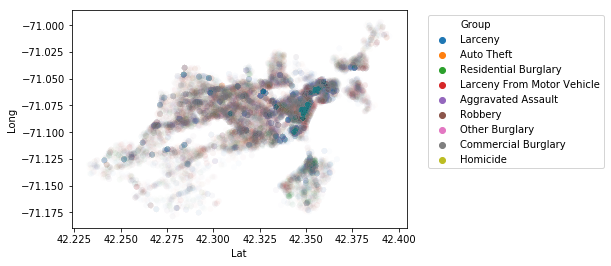

In [20]:
sns.scatterplot(x='Lat',
               y='Long',
                hue='Group',
                alpha=0.01,
               data=crime)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Let's use a difference sort of map which can show us a more fine grained new of the city, street by street.

In [21]:
# Create basic Folium crime map
crime_heatmap = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "OpenStreetMap",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = crime[crime.Year == 2017]
data_heatmap = crime[['Lat','Long']]
data_heatmap = crime.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_heatmap)

# Plot
crime_heatmap

In [22]:
# Create basic Folium crime map
crime_map = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "OpenStreetMap",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = larceny[larceny.Year == 2017]
data_heatmap = larceny[['Lat','Long']]
data_heatmap = larceny.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

#Plot
crime_map

Below, I will create a heatmap for homicides in Boston.

In [23]:
# Create basic Folium crime map
crime_map = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "OpenStreetMap",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = homicide[homicide.Year == 2017]
data_heatmap = homicide[['Lat','Long']]
data_heatmap = homicide.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot
crime_map

This map shows that most murders (which are recorded in our data) are centered around Dorchester, there seem to be very few murders recorded downtown. Since downtown is where a majority of other crimes happen this is very odd.